In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

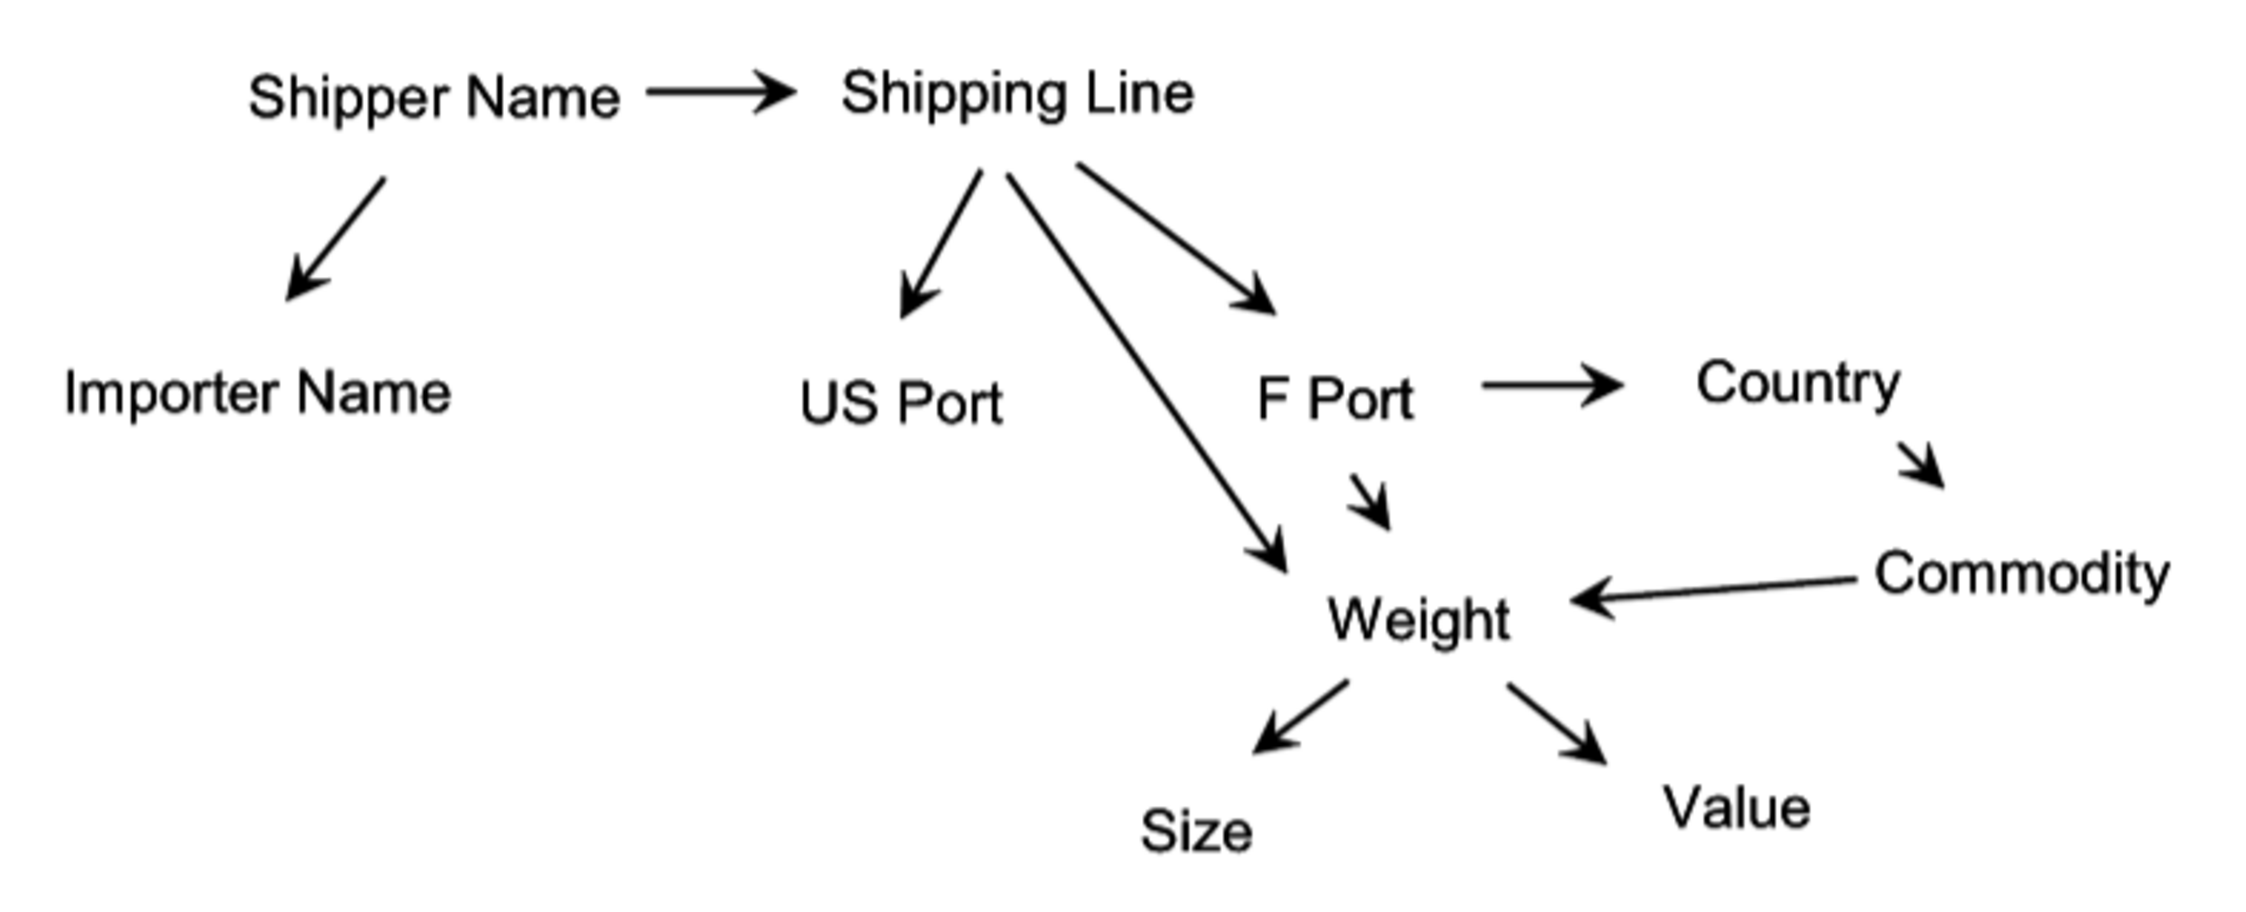

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):



### CI (Shipper Name, Value | F Port)? = Dependent

### CI (Shipper Name, Value | Shipping Line)? = Independent



### CI (Foreign Port, Commodity | Country)? = Independent



### CI (Foreign Port, Commodity | County, Weight)? = Dependent

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

## a) p(ASCO, Vancouver, Seattle, Heavy) = p(ASCO) * p(Vancouver | ASCO) * p(Seattle | ASCO) * p(Heavy | Vancouver, ASCO) = 0.3 * 1 * 1 * 0.15 = 0.045

## b) p(CSCO, Vancouver, Seattle, Heavy) = p(CSCO) * p(Vancouver | CSCO) * p(Seattle | CSCO) * p(Heavy | Vancouver, CSCO) = 0.7 * 0.6 * 0.8 * 0.2 = 0.0672

## c) p(CSCO, Yokohama, Los Angeles, Heavy) = p(CSCO) * p(Yokohama | CSCO) * p( Los Angeles | CSCO) * p(Heavy | Yokohama, CSCO) = 0.7 * 0.4 * 0.2 * 0.6 = 0.0336

## --> The most anomalous is package c (A heavy package shipped from Yokohama to Los Angeles by CSCO)

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [3]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

A  B  C  D  E  F
0  1  0  0  0  1  1
1  0  0  0  1  0  1
2  1  1  0  1  1  1
3  1  0  0  1  1  1
4  2  0  1  0  1  1

a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)



In [4]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianModel

In [5]:
hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = BayesianModel(hc.estimate().edges()) 
print(best_model.edges())

[('B', 'A'), ('D', 'A'), ('E', 'A')]


b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)



In [6]:
from pgmpy.estimators import BayesianEstimator

In [7]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for thenode in best_model.nodes():
    print(best_model.local_independencies(thenode))

CPD of B:
+------+--------+
| B(0) | 0.5015 |
+------+--------+
| B(1) | 0.4985 |
+------+--------+
CPD of A:
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| B    | B(0)                 | B(0)                  | B(0)                 | B(0)                 | B(1)                  | B(1)                 | B(1)                  | B(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| D    | D(0)                 | D(0)                  | D(1)                 | D(1)                 | D(0)                  | D(0)                 | D(1)                  | D(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [8]:
train_x = train.loc[:,['B','D','E']]
predicted_train = best_model.predict(train_x)
print("In sample:",(train.loc[:,'A'].reset_index(drop=True)==predicted_train['A']).mean())


100%|██████████| 8/8 [00:00<00:00, 65.91it/s]


In sample: 0.5766666666666667


In [9]:
test_x = test.loc[:,['B','D','E']]
predicted_test = best_model.predict(test_x)
print("Out of sample:",(test.loc[:,'A'].reset_index(drop=True)==predicted_test['A']).mean())

100%|██████████| 8/8 [00:00<00:00, 1724.54it/s]

Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [10]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

crime_type Category   day_Sun   day_Mon  \
0                          ARSON: BY FIRE      P1P  0.138810  0.135977   
1     ASSAULT: AGG PO HANDS NO/MIN INJURY       P2  0.151852  0.118519   
2            ASSAULT: AGGRAVATED: HANDGUN      P1V  0.149912  0.139405   
3  ASSAULT: AGGRAVATED: OTHER DANG WEAPON      P1V  0.125000  0.139000   
4      ASSAULT: AGGRAVATED: OTHER FIREARM      P1V  0.156863  0.107843   

    day_Tue   day_Wed   day_Thu   day_Fri   day_Sat    hour_0  ...  \
0  0.155807  0.121813  0.130312  0.147309  0.169972  0.073654  ...   
1  0.162963  0.122222  0.129630  0.129630  0.185185  0.055556  ...   
2  0.141506  0.131349  0.136953  0.133100  0.167776  0.040630  ...   
3  0.148000  0.153000  0.133000  0.142000  0.160000  0.034000  ...   
4  0.166667  0.117647  0.147059  0.117647  0.186275  0.009804  ...   

   community_area_68  community_area_69  community_area_70  community_area_71  \
0           0.019830           0.016997           0.019830           0.022663   
1           0.037037           0.048148           0.018519           0.025926   
2           0.035377           0.031524           0.013310           0.042732   
3           0.028000           0.030000           0.014000           0.037000   
4           0.029412           0.019608           0.009804           0.019608   

   community_area_72  community_area_73  community_area_74  community_area_75  \
0           0.005666           0.000000           0.002833           0.005666   
1           0.003704           0.003704           0.003704           0.011111   
2           0.002102           0.017863           0.000000           0.012259   
3           0.003000           0.010000           0.002000           0.002000   
4           0.000000           0.000000           0.000000           0.009804   

   community_area_76  community_area_77  
0           0.000000           0.002833  
1           0.011111           0.007407  
2           0.002102           0.003152  
3           0.003000           0.006000  
4           0.000000           0.000000  

[5 rows x 110 columns]

In [11]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

Community Area Number COMMUNITY AREA NAME   centroid_x   centroid_y  \
0                      1         Rogers Park  1164399.219  1947666.815   
1                      2          West Ridge  1158307.200  1943243.722   
2                      3              Uptown  1168228.082  1930980.022   
3                      4      Lincoln Square  1159618.804  1933105.743   
4                      5        North Center  1161104.228  1924056.010   

   PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
0                         7.7                              23.6   
1                         7.8                              17.2   
2                         3.8                              24.0   
3                         3.4                              10.9   
4                         0.3                               7.5   

   PERCENT AGED 16+ UNEMPLOYED  PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
0                          8.7                                          18.2   
1                          8.8                                          20.8   
2                          8.9                                          11.8   
3                          8.2                                          13.4   
4                          5.2                                           4.5   

   PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   \
0                              27.5               23939   
1                              38.5               23040   
2                              22.2               35787   
3                              25.5               37524   
4                              26.2               57123   

   PERCENT OF HOUSING UNITS VACANT  NUM_CRIMES_2016  
0                        11.870556             3420  
1                         9.870385             3068  
2                         8.672137             3330  
3                         8.600422             1859  
4                        10.100636             1280

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

In [12]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn import preprocessing


In [13]:
data3.shape

(119, 110)

In [14]:
data_a=data3.iloc[:,np.r_[1,9:33]]
data_a.head()


Category    hour_0    hour_1    hour_2    hour_3    hour_4    hour_5  \
0      P1P  0.073654  0.079320  0.076487  0.087819  0.082153  0.073654   
1       P2  0.055556  0.070370  0.033333  0.014815  0.025926  0.003704   
2      P1V  0.040630  0.039580  0.033275  0.036778  0.018564  0.014011   
3      P1V  0.034000  0.026000  0.018000  0.009000  0.010000  0.015000   
4      P1V  0.009804  0.009804  0.029412  0.009804  0.009804  0.019608   

     hour_6    hour_7    hour_8  ...   hour_14   hour_15   hour_16   hour_17  \
0  0.039660  0.033994  0.014164  ...  0.019830  0.019830  0.025496  0.022663   
1  0.007407  0.014815  0.018519  ...  0.055556  0.077778  0.048148  0.059259   
2  0.012609  0.021366  0.025569  ...  0.055342  0.052189  0.059895  0.056392   
3  0.020000  0.017000  0.033000  ...  0.045000  0.058000  0.073000  0.078000   
4  0.039216  0.019608  0.000000  ...  0.029412  0.009804  0.107843  0.117647   

    hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  
0  0.022663  0.053824  0.033994  0.033994  0.042493  0.062323  
1  0.044444  0.044444  0.077778  0.044444  0.074074  0.044444  
2  0.062347  0.051839  0.053240  0.066550  0.055692  0.056042  
3  0.068000  0.066000  0.059000  0.038000  0.051000  0.041000  
4  0.058824  0.068627  0.078431  0.068627  0.049020  0.088235  

[5 rows x 25 columns]

In [15]:
test = preprocessing.normalize(data_a.iloc[:,1:])
test.shape

(119, 24)

In [16]:
test

array([[0.31131586, 0.33526323, 0.32328954, ..., 0.14368424, 0.1796053 ,
        0.26342111],
       [0.24256734, 0.30725196, 0.1455404 , ..., 0.19405387, 0.32342311,
        0.19405387],
       [0.18692835, 0.182094  , 0.15308787, ..., 0.30617575, 0.25622076,
        0.25783221],
       ...,
       [0.20975133, 0.12585079, 0.07047645, ..., 0.35238223, 0.37251836,
        0.31210997],
       [0.32955593, 0.13182237, 0.09886678, ..., 0.14830017, 0.37898932,
        0.19773356],
       [0.08495482, 0.22654619, 0.08495482, ..., 0.25486446, 0.25486446,
        0.19822792]])

In [17]:
km = KMeans(random_state = 123, n_clusters = 3)
km_test = km.fit(test)
km_test

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [18]:
labels = km.labels_
labels

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1,
       2, 1, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 2, 0, 2], dtype=int32)

In [19]:
hours = pd.concat([pd.Series(labels),data3.iloc[:,9:33]], axis = 1)
hours.rename(columns = {0:'Label'}, inplace = True)
hours.head()

Label    hour_0    hour_1    hour_2    hour_3    hour_4    hour_5  \
0      0  0.073654  0.079320  0.076487  0.087819  0.082153  0.073654   
1      0  0.055556  0.070370  0.033333  0.014815  0.025926  0.003704   
2      0  0.040630  0.039580  0.033275  0.036778  0.018564  0.014011   
3      1  0.034000  0.026000  0.018000  0.009000  0.010000  0.015000   
4      0  0.009804  0.009804  0.029412  0.009804  0.009804  0.019608   

     hour_6    hour_7    hour_8  ...   hour_14   hour_15   hour_16   hour_17  \
0  0.039660  0.033994  0.014164  ...  0.019830  0.019830  0.025496  0.022663   
1  0.007407  0.014815  0.018519  ...  0.055556  0.077778  0.048148  0.059259   
2  0.012609  0.021366  0.025569  ...  0.055342  0.052189  0.059895  0.056392   
3  0.020000  0.017000  0.033000  ...  0.045000  0.058000  0.073000  0.078000   
4  0.039216  0.019608  0.000000  ...  0.029412  0.009804  0.107843  0.117647   

    hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  
0  0.022663  0.053824  0.033994  0.033994  0.042493  0.062323  
1  0.044444  0.044444  0.077778  0.044444  0.074074  0.044444  
2  0.062347  0.051839  0.053240  0.066550  0.055692  0.056042  
3  0.068000  0.066000  0.059000  0.038000  0.051000  0.041000  
4  0.058824  0.068627  0.078431  0.068627  0.049020  0.088235  

[5 rows x 25 columns]

In [20]:
hour = hours.groupby(by = hours['Label']).mean()
hour

hour_0    hour_1    hour_2    hour_3    hour_4    hour_5    hour_6  \
Label                                                                         
0      0.057301  0.046068  0.042562  0.035510  0.027600  0.019383  0.019477   
1      0.043175  0.016547  0.014350  0.012420  0.012388  0.011705  0.016398   
2      0.025377  0.017847  0.009935  0.005549  0.003112  0.001474  0.003687   

         hour_7    hour_8    hour_9  ...   hour_14   hour_15   hour_16  \
Label                                ...                                 
0      0.022168  0.024408  0.029435  ...  0.038151  0.042822  0.049133   
1      0.026903  0.046392  0.076433  ...  0.059539  0.065968  0.060944   
2      0.009625  0.014765  0.026643  ...  0.058730  0.046101  0.041701   

        hour_17   hour_18   hour_19   hour_20   hour_21   hour_22   hour_23  
Label                                                                        
0      0.050790  0.055742  0.056758  0.063003  0.060591  0.063900  0.056050  
1      0.056536  0.053080  0.044565  0.038841  0.029228  0.028425  0.025582  
2      0.046158  0.074026  0.104360  0.082271  0.073417  0.063225  0.039211  

[3 rows x 24 columns]

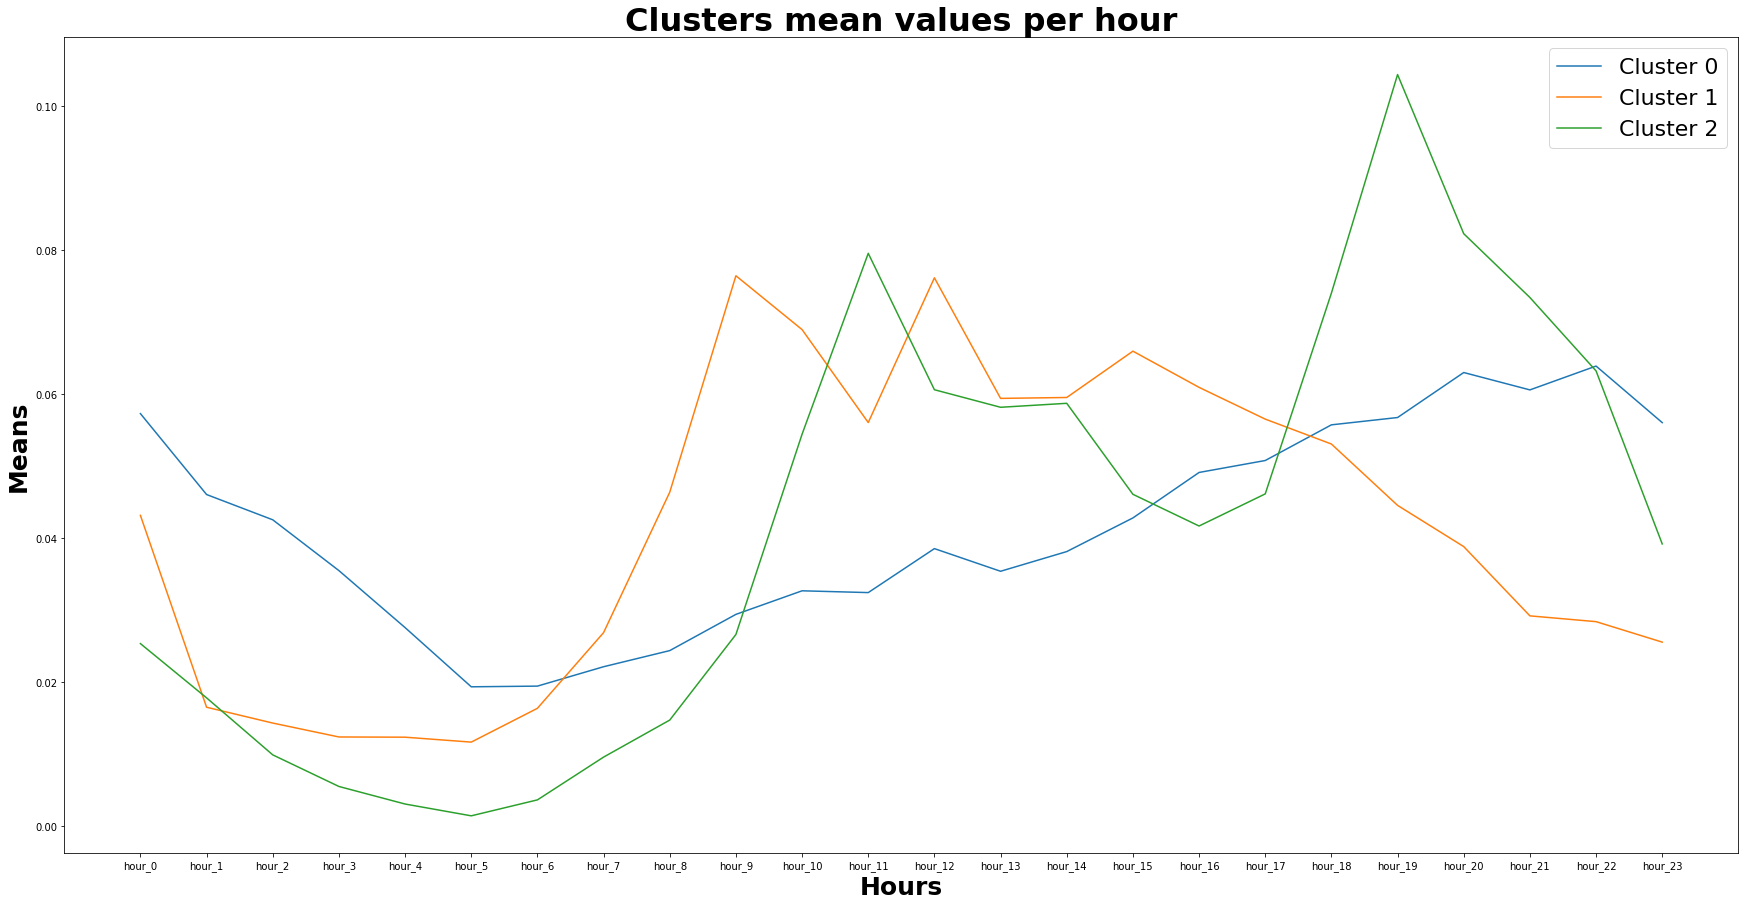

In [21]:
plt.figure(figsize = (30,15))
plt.plot(hour.T)


plt.xlabel('Hours', weight='bold',fontsize=25)
plt.ylabel('Means', weight='bold', fontsize=25)
plt.title('Clusters mean values per hour', weight='bold',fontsize=32)
plt.legend(['Cluster 0','Cluster 1', 'Cluster 2'],fontsize=22)

plt.show()


b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

##  Cluster 0 follows at first a downward trend until it reach its lowest peak at 5am. However, starting 6am the trend starts to experience a steady increase until 10pm where the trend switches downward again.   

## Cluster 1 starts with a downward trend until 5am as well. However, it experiences a very sharp increase starting 6am until 9am where it reaches its highest peak to drastically fall down until 11am. After that, the cluster goes through another sharp increase until 12pm, where it once again undergoes a sharp decrease which becomes a little bit more steady around 2pm to gradually start decreasing.

## Cluster 2 follows a similar starting trend to cluster 1. However, it reaches its highest peak around 11am before experiencing a sudden decrease until 5pm where the trend shifts upward very fast to reach the highest peak of all clusters around 7pm before drastically falling down after that peak.


c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)

In [22]:
crime_type = pd.concat([pd.Series(labels), data3.iloc[:,0]], axis = 1)
crime_type.rename(columns = {0:'Label'}, inplace = True)
crime_type.head(10)

Label                                     crime_type
0      0                                 ARSON: BY FIRE
1      0            ASSAULT: AGG PO HANDS NO/MIN INJURY
2      0                   ASSAULT: AGGRAVATED: HANDGUN
3      1         ASSAULT: AGGRAVATED: OTHER DANG WEAPON
4      0             ASSAULT: AGGRAVATED: OTHER FIREARM
5      0        ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR
6      1           ASSAULT: PRO EMP HANDS NO/MIN INJURY
7      1                                ASSAULT: SIMPLE
8      0            BATTERY: AGG PO HANDS NO/MIN INJURY
9      1  BATTERY: AGG: HANDS/FIST/FEET NO/MINOR INJURY

In [23]:
crime_0 = crime_type.loc[crime_type['Label'] == 0]
crime_0.crime_type

0                                         ARSON: BY FIRE
1                    ASSAULT: AGG PO HANDS NO/MIN INJURY
2                           ASSAULT: AGGRAVATED: HANDGUN
4                     ASSAULT: AGGRAVATED: OTHER FIREARM
5                ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR
8                    BATTERY: AGG PO HANDS NO/MIN INJURY
10          BATTERY: AGG: HANDS/FIST/FEET SERIOUS INJURY
11     BATTERY: AGGRAVATED DOMESTIC BATTERY: HANDS/FI...
12     BATTERY: AGGRAVATED DOMESTIC BATTERY: KNIFE/CU...
13     BATTERY: AGGRAVATED DOMESTIC BATTERY: OTHER DA...
15                          BATTERY: AGGRAVATED: HANDGUN
16                BATTERY: AGGRAVATED: OTHER DANG WEAPON
17               BATTERY: AGGRAVATED:KNIFE/CUTTING INSTR
18                      BATTERY: DOMESTIC BATTERY SIMPLE
20                                       BATTERY: SIMPLE
23                               BURGLARY: HOME INVASION
25                CRIM SEXUAL ASSAULT: AGGRAVATED: OTHER
26                   CRIM SEXUA

In [24]:
crime_1 = crime_type.loc[crime_type['Label'] == 1]
crime_1.crime_type

3                 ASSAULT: AGGRAVATED: OTHER DANG WEAPON
6                   ASSAULT: PRO EMP HANDS NO/MIN INJURY
7                                        ASSAULT: SIMPLE
9          BATTERY: AGG: HANDS/FIST/FEET NO/MINOR INJURY
14               BATTERY: AGGRAVATED OF A SENIOR CITIZEN
19                  BATTERY: PRO EMP HANDS NO/MIN INJURY
21                      BURGLARY: ATTEMPT FORCIBLE ENTRY
22                              BURGLARY: FORCIBLE ENTRY
24                              BURGLARY: UNLAWFUL ENTRY
33                       CRIMINAL TRESPASS: TO RESIDENCE
34                  CRIMINAL TRESPASS: TO STATE SUP LAND
36     DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTI...
37                       DECEPTIVE PRACTICE: BOGUS CHECK
38                 DECEPTIVE PRACTICE: COUNTERFEIT CHECK
40                 DECEPTIVE PRACTICE: CREDIT CARD FRAUD
41     DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT $...
42     DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT O...
43                           DE

In [25]:
crime_2 = crime_type.loc[crime_type['Label'] == 2]
crime_2.crime_type

32                            CRIMINAL TRESPASS: TO LAND
39           DECEPTIVE PRACTICE: COUNTERFEITING DOCUMENT
48                                   GAMBLING: GAME/DICE
50     INTERFERENCE WITH PUBLIC OFFICER: OBSTRUCTING ...
57             NARCOTICS: MANU/DEL:CANNABIS 10GM OR LESS
58              NARCOTICS: MANU/DEL:CANNABIS OVER 10 GMS
59               NARCOTICS: MANU/DELIVER: HEROIN (WHITE)
60                         NARCOTICS: MANU/DELIVER:CRACK
62               NARCOTICS: POSS: CANNABIS 30GMS OR LESS
63             NARCOTICS: POSS: CANNABIS MORE THAN 30GMS
65                                NARCOTICS: POSS: CRACK
66                        NARCOTICS: POSS: HEROIN(WHITE)
67                                  NARCOTICS: POSS: PCP
68                      NARCOTICS: POSS: SYNTHETIC DRUGS
69               NARCOTICS: POSSESSION OF DRUG EQUIPMENT
70             NARCOTICS: SOLICIT NARCOTICS ON PUBLICWAY
77      OTHER OFFENSE: GUN OFFENDER: ANNUAL REGISTRATION
78         OTHER OFFENSE: GUN O

## The type of crimes assigned to:
## -Cluster 0 are mostly about assaults, battery, thefts and robberies.
## -Cluster 1 are mostly about assaults, deceptive practices and thefts.
## -Ccluster 2 are mostly about narcotics.
## Apart from cluster 2 where narcotics-related crimes are mostly clustered in, cluster 0 and 1 are a mix of different types of criminal offenses and activities.

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)


In [26]:
data_b=data3.iloc[:,np.r_[1,2:9]]
data_b.head()

Category   day_Sun   day_Mon   day_Tue   day_Wed   day_Thu   day_Fri  \
0      P1P  0.138810  0.135977  0.155807  0.121813  0.130312  0.147309   
1       P2  0.151852  0.118519  0.162963  0.122222  0.129630  0.129630   
2      P1V  0.149912  0.139405  0.141506  0.131349  0.136953  0.133100   
3      P1V  0.125000  0.139000  0.148000  0.153000  0.133000  0.142000   
4      P1V  0.156863  0.107843  0.166667  0.117647  0.147059  0.117647   

    day_Sat  
0  0.169972  
1  0.185185  
2  0.167776  
3  0.160000  
4  0.186275

In [27]:
test2 = preprocessing.normalize(data_b.iloc[:,1:])
test2.shape

(119, 7)

In [28]:
test2

array([[0.36523458, 0.35778081, 0.40995718, 0.32051198, 0.34287328,
        0.38759588, 0.44722602],
       [0.39673291, 0.3096452 , 0.42576215, 0.31932161, 0.33867444,
        0.33867444, 0.48382062],
       [0.39532291, 0.36761336, 0.37315527, 0.34636937, 0.3611478 ,
        0.35098763, 0.44242915],
       [0.32973382, 0.36666401, 0.39040484, 0.4035942 , 0.35083679,
        0.37457762, 0.42205929],
       [0.40771775, 0.28030595, 0.43320011, 0.30578831, 0.38223539,
        0.30578831, 0.48416483],
       [0.40917802, 0.37755073, 0.36371379, 0.39731778, 0.35580697,
        0.3676672 , 0.37162061],
       [0.07288958, 0.3472974 , 0.44162509, 0.57025376, 0.42876223,
        0.39446125, 0.12005342],
       [0.35407241, 0.38587127, 0.39647089, 0.39376461, 0.38767546,
        0.38068422, 0.34392384],
       [0.40265333, 0.31317481, 0.33554444, 0.34896622, 0.3981794 ,
        0.43397081, 0.3981794 ],
       [0.29910403, 0.35892484, 0.49850672, 0.3190443 , 0.35892484,
        0.39880537, 0.3

In [29]:
km2 = KMeans(random_state = 123, n_clusters = 3)
km_test2 = km2.fit(test2)
km_test2

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [30]:
labels2 = km2.labels_
labels2

array([2, 2, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1,
       1, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0,
       0, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2,
       1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 2, 0], dtype=int32)

In [31]:
days = pd.concat([pd.Series(labels2),data3.iloc[:,2:9]], axis = 1)
days.rename(columns = {0:'Label'}, inplace = True)
days.head()

Label   day_Sun   day_Mon   day_Tue   day_Wed   day_Thu   day_Fri   day_Sat
0      2  0.138810  0.135977  0.155807  0.121813  0.130312  0.147309  0.169972
1      2  0.151852  0.118519  0.162963  0.122222  0.129630  0.129630  0.185185
2      2  0.149912  0.139405  0.141506  0.131349  0.136953  0.133100  0.167776
3      0  0.125000  0.139000  0.148000  0.153000  0.133000  0.142000  0.160000
4      2  0.156863  0.107843  0.166667  0.117647  0.147059  0.117647  0.186275

In [32]:
day = days.groupby(by = days['Label']).mean()
day

day_Sun   day_Mon   day_Tue   day_Wed   day_Thu   day_Fri   day_Sat
Label                                                                      
0      0.128685  0.153311  0.147893  0.141619  0.141885  0.150214  0.136395
1      0.077758  0.139322  0.172279  0.170614  0.171243  0.167287  0.101498
2      0.168935  0.127610  0.127153  0.126090  0.127152  0.149885  0.173176

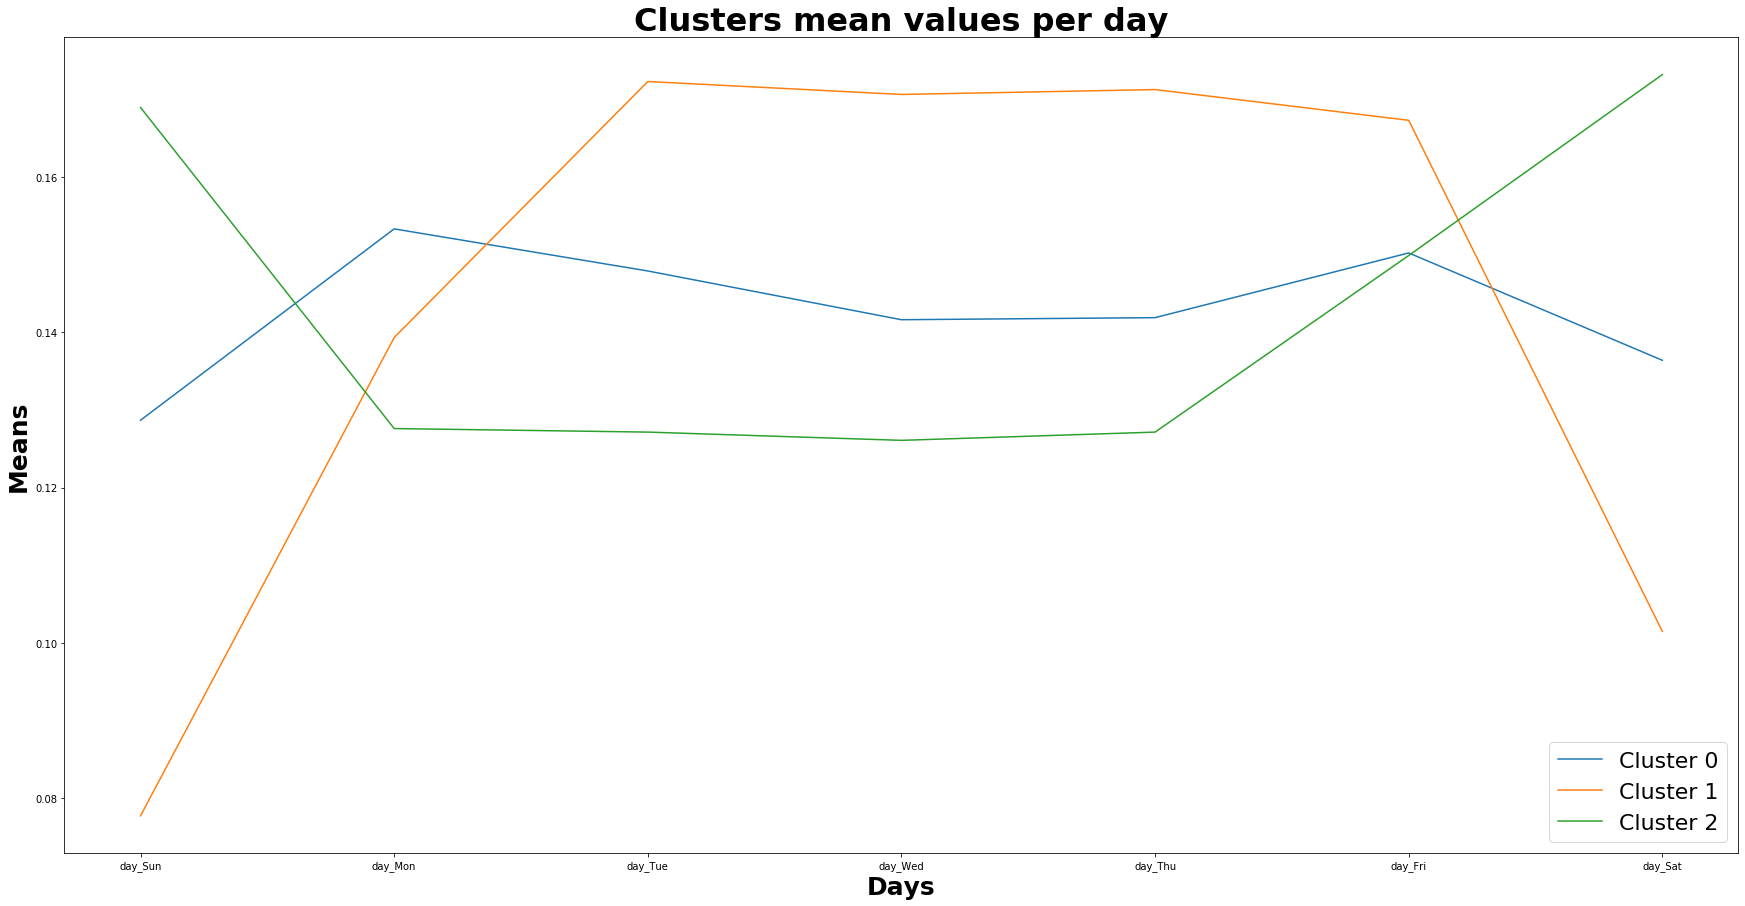

In [33]:
plt.figure(figsize = (30,15))
plt.plot(day.T)


plt.xlabel('Days', weight='bold',fontsize=25)
plt.ylabel('Means', weight='bold', fontsize=25)
plt.title('Clusters mean values per day', weight='bold',fontsize=32)
plt.legend(['Cluster 0','Cluster 1', 'Cluster 2'],fontsize=22)

plt.show()


e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)



In [34]:
data_c = data3.iloc[:,33:]
data_c.head()

community_area_1  community_area_2  community_area_3  community_area_4  \
0          0.005666          0.008499          0.002833          0.000000   
1          0.014815          0.011111          0.014815          0.003704   
2          0.009107          0.009457          0.006655          0.003152   
3          0.014000          0.011000          0.014000          0.003000   
4          0.000000          0.009804          0.000000          0.009804   

   community_area_5  community_area_6  community_area_7  community_area_8  \
0          0.000000          0.005666          0.011331          0.002833   
1          0.003704          0.018519          0.003704          0.011111   
2          0.002102          0.003152          0.001751          0.010158   
3          0.006000          0.012000          0.004000          0.021000   
4          0.009804          0.019608          0.000000          0.000000   

   community_area_9  community_area_10  ...  community_area_68  \
0             0.000           0.000000  ...           0.019830   
1             0.000           0.007407  ...           0.037037   
2             0.000           0.002102  ...           0.035377   
3             0.001           0.002000  ...           0.028000   
4             0.000           0.009804  ...           0.029412   

   community_area_69  community_area_70  community_area_71  community_area_72  \
0           0.016997           0.019830           0.022663           0.005666   
1           0.048148           0.018519           0.025926           0.003704   
2           0.031524           0.013310           0.042732           0.002102   
3           0.030000           0.014000           0.037000           0.003000   
4           0.019608           0.009804           0.019608           0.000000   

   community_area_73  community_area_74  community_area_75  community_area_76  \
0           0.000000           0.002833           0.005666           0.000000   
1           0.003704           0.003704           0.011111           0.011111   
2           0.017863           0.000000           0.012259           0.002102   
3           0.010000           0.002000           0.002000           0.003000   
4           0.000000           0.000000           0.009804           0.000000   

   community_area_77  
0           0.002833  
1           0.007407  
2           0.003152  
3           0.006000  
4           0.000000  

[5 rows x 77 columns]

In [35]:
test3 = preprocessing.normalize(data_c.iloc[:,1:])
test3.shape

(119, 76)

In [36]:
test3

array([[0.04719292, 0.01573097, 0.        , ..., 0.03146194, 0.        ,
        0.01573097],
       [0.06425294, 0.08567059, 0.02141765, ..., 0.06425294, 0.06425294,
        0.04283529],
       [0.05757532, 0.04051596, 0.01919177, ..., 0.07463467, 0.01279451,
        0.01919177],
       ...,
       [0.03683609, 0.01432515, 0.00613935, ..., 0.02865029, 0.0040929 ,
        0.01023225],
       [0.148072  , 0.166581  , 0.148072  , ..., 0.074036  , 0.        ,
        0.166581  ],
       [0.        , 0.03857584, 0.07715167, ..., 0.        , 0.        ,
        0.03857584]])

In [37]:
km3 = KMeans(random_state = 123, n_clusters = 3)
km_test3 = km3.fit(test3)
km_test3

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [38]:
labels3 = km3.labels_
labels3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2,
       2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 2, 0], dtype=int32)

In [39]:
comm = pd.concat([pd.Series(labels3),data3.iloc[:,33:]], axis = 1)
comm.rename(columns = {0:'Label'}, inplace = True)
comm.head()

Label  community_area_1  community_area_2  community_area_3  \
0      0          0.005666          0.008499          0.002833   
1      0          0.014815          0.011111          0.014815   
2      0          0.009107          0.009457          0.006655   
3      0          0.014000          0.011000          0.014000   
4      0          0.000000          0.009804          0.000000   

   community_area_4  community_area_5  community_area_6  community_area_7  \
0          0.000000          0.000000          0.005666          0.011331   
1          0.003704          0.003704          0.018519          0.003704   
2          0.003152          0.002102          0.003152          0.001751   
3          0.003000          0.006000          0.012000          0.004000   
4          0.009804          0.009804          0.019608          0.000000   

   community_area_8  community_area_9  ...  community_area_68  \
0          0.002833             0.000  ...           0.019830   
1          0.011111             0.000  ...           0.037037   
2          0.010158             0.000  ...           0.035377   
3          0.021000             0.001  ...           0.028000   
4          0.000000             0.000  ...           0.029412   

   community_area_69  community_area_70  community_area_71  community_area_72  \
0           0.016997           0.019830           0.022663           0.005666   
1           0.048148           0.018519           0.025926           0.003704   
2           0.031524           0.013310           0.042732           0.002102   
3           0.030000           0.014000           0.037000           0.003000   
4           0.019608           0.009804           0.019608           0.000000   

   community_area_73  community_area_74  community_area_75  community_area_76  \
0           0.000000           0.002833           0.005666           0.000000   
1           0.003704           0.003704           0.011111           0.011111   
2           0.017863           0.000000           0.012259           0.002102   
3           0.010000           0.002000           0.002000           0.003000   
4           0.000000           0.000000           0.009804           0.000000   

   community_area_77  
0           0.002833  
1           0.007407  
2           0.003152  
3           0.006000  
4           0.000000  

[5 rows x 78 columns]

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)



In [40]:
data3['Category'].value_counts()

P2     80
P1V    24
P1P    15
Name: Category, dtype: int64

In [41]:
hours['Label'].value_counts()

0    53
1    41
2    25
Name: Label, dtype: int64

In [42]:
t1 = data3.loc[data3['Category'] == 'P1V']
t1.crime_type

2                           ASSAULT: AGGRAVATED: HANDGUN
3                 ASSAULT: AGGRAVATED: OTHER DANG WEAPON
4                     ASSAULT: AGGRAVATED: OTHER FIREARM
5                ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR
10          BATTERY: AGG: HANDS/FIST/FEET SERIOUS INJURY
11     BATTERY: AGGRAVATED DOMESTIC BATTERY: HANDS/FI...
12     BATTERY: AGGRAVATED DOMESTIC BATTERY: KNIFE/CU...
13     BATTERY: AGGRAVATED DOMESTIC BATTERY: OTHER DA...
14               BATTERY: AGGRAVATED OF A SENIOR CITIZEN
15                          BATTERY: AGGRAVATED: HANDGUN
16                BATTERY: AGGRAVATED: OTHER DANG WEAPON
17               BATTERY: AGGRAVATED:KNIFE/CUTTING INSTR
25                CRIM SEXUAL ASSAULT: AGGRAVATED: OTHER
26                   CRIM SEXUAL ASSAULT: NON-AGGRAVATED
49                         HOMICIDE: FIRST DEGREE MURDER
95                                   ROBBERY: AGGRAVATED
96               ROBBERY: AGGRAVATED VEHICULAR HIJACKING
97                             

In [43]:
crime_2.crime_type

32                            CRIMINAL TRESPASS: TO LAND
39           DECEPTIVE PRACTICE: COUNTERFEITING DOCUMENT
48                                   GAMBLING: GAME/DICE
50     INTERFERENCE WITH PUBLIC OFFICER: OBSTRUCTING ...
57             NARCOTICS: MANU/DEL:CANNABIS 10GM OR LESS
58              NARCOTICS: MANU/DEL:CANNABIS OVER 10 GMS
59               NARCOTICS: MANU/DELIVER: HEROIN (WHITE)
60                         NARCOTICS: MANU/DELIVER:CRACK
62               NARCOTICS: POSS: CANNABIS 30GMS OR LESS
63             NARCOTICS: POSS: CANNABIS MORE THAN 30GMS
65                                NARCOTICS: POSS: CRACK
66                        NARCOTICS: POSS: HEROIN(WHITE)
67                                  NARCOTICS: POSS: PCP
68                      NARCOTICS: POSS: SYNTHETIC DRUGS
69               NARCOTICS: POSSESSION OF DRUG EQUIPMENT
70             NARCOTICS: SOLICIT NARCOTICS ON PUBLICWAY
77      OTHER OFFENSE: GUN OFFENDER: ANNUAL REGISTRATION
78         OTHER OFFENSE: GUN O

## Comparatively, the proportions of the clusters vs. the FBI's division are very different. After noticing that P1V had similar proportion to cluster 2, I attempted to compare the type of crimes but they were different. The clustering does not correspond well to the FBI's division

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [44]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [45]:
label_days = data_b.columns[1:]

In [46]:
datag = test2
datag

array([[0.36523458, 0.35778081, 0.40995718, 0.32051198, 0.34287328,
        0.38759588, 0.44722602],
       [0.39673291, 0.3096452 , 0.42576215, 0.31932161, 0.33867444,
        0.33867444, 0.48382062],
       [0.39532291, 0.36761336, 0.37315527, 0.34636937, 0.3611478 ,
        0.35098763, 0.44242915],
       [0.32973382, 0.36666401, 0.39040484, 0.4035942 , 0.35083679,
        0.37457762, 0.42205929],
       [0.40771775, 0.28030595, 0.43320011, 0.30578831, 0.38223539,
        0.30578831, 0.48416483],
       [0.40917802, 0.37755073, 0.36371379, 0.39731778, 0.35580697,
        0.3676672 , 0.37162061],
       [0.07288958, 0.3472974 , 0.44162509, 0.57025376, 0.42876223,
        0.39446125, 0.12005342],
       [0.35407241, 0.38587127, 0.39647089, 0.39376461, 0.38767546,
        0.38068422, 0.34392384],
       [0.40265333, 0.31317481, 0.33554444, 0.34896622, 0.3981794 ,
        0.43397081, 0.3981794 ],
       [0.29910403, 0.35892484, 0.49850672, 0.3190443 , 0.35892484,
        0.39880537, 0.3

## 1. k-means

In [47]:
data_day = data_b.iloc[:,1:]
data_day.head()

day_Sun   day_Mon   day_Tue   day_Wed   day_Thu   day_Fri   day_Sat
0  0.138810  0.135977  0.155807  0.121813  0.130312  0.147309  0.169972
1  0.151852  0.118519  0.162963  0.122222  0.129630  0.129630  0.185185
2  0.149912  0.139405  0.141506  0.131349  0.136953  0.133100  0.167776
3  0.125000  0.139000  0.148000  0.153000  0.133000  0.142000  0.160000
4  0.156863  0.107843  0.166667  0.117647  0.147059  0.117647  0.186275

In [48]:
for n_clusters in range(2,10):
    km = KMeans(n_clusters=n_clusters, random_state=123)
    km.fit(datag)
    cluster_labels = km.labels_
    silhouette = silhouette_score(data_day, cluster_labels)
    print("For clusters = {0}, the silhouette score is {1}".format(n_clusters,silhouette))
    df = pd.concat([pd.Series(cluster_labels),data_day], axis = 1)
    print('\nThe number of elements in each cluster is: \n{}\n'.format(df[0].value_counts()))    

For clusters = 2, the silhouette score is 0.2365303906851532

The number of elements in each cluster is: 
0    60
1    59
Name: 0, dtype: int64

For clusters = 3, the silhouette score is 0.21902614573619494

The number of elements in each cluster is: 
0    61
2    37
1    21
Name: 0, dtype: int64

For clusters = 4, the silhouette score is 0.22331332600933246

The number of elements in each cluster is: 
1    56
2    45
3    16
0     2
Name: 0, dtype: int64

For clusters = 5, the silhouette score is 0.23963777889548413

The number of elements in each cluster is: 
1    64
2    34
3    15
0     4
4     2
Name: 0, dtype: int64

For clusters = 6, the silhouette score is 0.16708842567923882

The number of elements in each cluster is: 
2    43
3    34
0    24
1    13
5     3
4     2
Name: 0, dtype: int64

For clusters = 7, the silhouette score is 0.1787927601665452

The number of elements in each cluster is: 
0    47
6    31
3    24
1    11
5     2
4     2
2     2
Name: 0, dtype: int64

For cl

### The highest silhouette score is achieved with cluster 5

## 2. Gaussian Mixture Models

In [49]:
from sklearn.mixture import GaussianMixture
from scipy import linalg

In [50]:
for n_clusters in range(2,10):
    gmm = GaussianMixture(n_components=n_clusters, random_state=123)
    gmm.fit(datag)
    labels = gmm.predict(datag)
    silhouette = silhouette_score(data_day, labels)
    print("For clusters = {0}, the silhouette score is {1}".format(n_clusters,silhouette))
    df = pd.concat([pd.Series(labels),data_day], axis = 1)
    print('\nThe number of elements in each cluster is: \n{}\n'.format(df[0].value_counts()))

For clusters = 2, the silhouette score is 0.2648995822751991

The number of elements in each cluster is: 
1    83
0    36
Name: 0, dtype: int64

For clusters = 3, the silhouette score is 0.2769516535626227

The number of elements in each cluster is: 
2    89
1    19
0    11
Name: 0, dtype: int64

For clusters = 4, the silhouette score is 0.27022942577081205

The number of elements in each cluster is: 
1    85
2    20
0    12
3     2
Name: 0, dtype: int64

For clusters = 5, the silhouette score is 0.16064152816951266

The number of elements in each cluster is: 
1    60
2    36
4    13
0     8
3     2
Name: 0, dtype: int64

For clusters = 6, the silhouette score is 0.17024676028232502

The number of elements in each cluster is: 
5    55
1    33
0    14
4     8
2     7
3     2
Name: 0, dtype: int64

For clusters = 7, the silhouette score is 0.14131266081871321

The number of elements in each cluster is: 
6    46
1    24
5    14
4    12
0    12
2     9
3     2
Name: 0, dtype: int64

For cl

### The highest silhouette score is achieved with cluster 3

## 3. Bottom-up hierarchical clustering with "single link" distance metric

In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

In [52]:
Z = linkage(datag, 'single')

for n_clusters in range(2,10):
    cluster_labels=fcluster(Z, n_clusters, criterion='maxclust')    
    silhouette = silhouette_score(data_day, cluster_labels)
    print("For clusters = {0}, the silhouette score is {1}".format(n_clusters,silhouette))
    df = pd.concat([pd.Series(cluster_labels),data_day], axis = 1)
    print('\nThe number of elements in each cluster is: \n{}\n'.format(df[0].value_counts()))

For clusters = 2, the silhouette score is 0.6377648080667613

The number of elements in each cluster is: 
1    118
2      1
Name: 0, dtype: int64

For clusters = 3, the silhouette score is 0.5568477382969328

The number of elements in each cluster is: 
1    117
3      1
2      1
Name: 0, dtype: int64

For clusters = 4, the silhouette score is 0.40557775075981567

The number of elements in each cluster is: 
2    115
1      2
4      1
3      1
Name: 0, dtype: int64

For clusters = 5, the silhouette score is 0.38770381887486705

The number of elements in each cluster is: 
2    114
1      2
5      1
4      1
3      1
Name: 0, dtype: int64

For clusters = 6, the silhouette score is 0.34321300241481023

The number of elements in each cluster is: 
2    113
1      2
6      1
5      1
4      1
3      1
Name: 0, dtype: int64

For clusters = 7, the silhouette score is 0.3462184482039438

The number of elements in each cluster is: 
2    112
1      2
7      1
6      1
5      1
4      1
3      1
Nam

### The highest silhouette score is achieved with cluster 2

## 4. Bottom-up hierarchical clustering with "complete link" distance metric

In [53]:
Z = linkage(datag, 'complete')

for n_clusters in range(2,10):
    cluster_labels=fcluster(Z, n_clusters, criterion='maxclust')    
    silhouette = silhouette_score(data_day, cluster_labels)
    print("For clusters = {0}, the silhouette score is {1}".format(n_clusters,silhouette))
    df = pd.concat([pd.Series(cluster_labels),data_day], axis = 1)
    print('\nThe number of elements in each cluster is: \n{}\n'.format(df[0].value_counts()))

For clusters = 2, the silhouette score is 0.6100646113547021

The number of elements in each cluster is: 
2    117
1      2
Name: 0, dtype: int64

For clusters = 3, the silhouette score is 0.209380846250042

The number of elements in each cluster is: 
2    66
3    51
1     2
Name: 0, dtype: int64

For clusters = 4, the silhouette score is 0.22016516968998695

The number of elements in each cluster is: 
2    66
4    46
3     5
1     2
Name: 0, dtype: int64

For clusters = 5, the silhouette score is 0.21424928981226757

The number of elements in each cluster is: 
2    52
5    46
3    14
4     5
1     2
Name: 0, dtype: int64

For clusters = 6, the silhouette score is 0.21557090355513533

The number of elements in each cluster is: 
2    52
6    46
3    13
5     5
1     2
4     1
Name: 0, dtype: int64

For clusters = 7, the silhouette score is 0.15551776349035848

The number of elements in each cluster is: 
2    52
7    36
3    13
6    10
5     5
1     2
4     1
Name: 0, dtype: int64

For c

### The highest silhouette score is achieved with cluster 2

## We notice that they mostly display different cluster numbers. However, hierarchical clustering gives an optimal cluster number of 2 for both methods